# Sciplex Dose

In [1]:
ood_seed = 9

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Nutlin', '50.0'), 265)


Removed datapoint: 265

train         11594
validation     2952
ood             265
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 58%|█████▊    | 8527/14811 [00:00<00:00, 85261.34it/s]

100%|██████████| 14811/14811 [00:00<00:00, 91017.94it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 903577.21it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 162.94it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:04<31:48,  4.78s/it]

Epoch 1/400:   0%|          | 1/400 [00:04<31:48,  4.78s/it, v_num=1, recon=3.08e+3, r2_mean=0.126, adv_loss=1.49, acc_pert=0.337]

Epoch 2/400:   0%|          | 1/400 [00:04<31:48,  4.78s/it, v_num=1, recon=3.08e+3, r2_mean=0.126, adv_loss=1.49, acc_pert=0.337]

Epoch 2/400:   0%|          | 2/400 [00:08<28:35,  4.31s/it, v_num=1, recon=3.08e+3, r2_mean=0.126, adv_loss=1.49, acc_pert=0.337]

Epoch 2/400:   0%|          | 2/400 [00:08<28:35,  4.31s/it, v_num=1, recon=2.34e+3, r2_mean=0.482, adv_loss=1.29, acc_pert=0.447]

Epoch 3/400:   0%|          | 2/400 [00:08<28:35,  4.31s/it, v_num=1, recon=2.34e+3, r2_mean=0.482, adv_loss=1.29, acc_pert=0.447]

Epoch 3/400:   1%|          | 3/400 [00:16<40:14,  6.08s/it, v_num=1, recon=2.34e+3, r2_mean=0.482, adv_loss=1.29, acc_pert=0.447]

Epoch 3/400:   1%|          | 3/400 [00:16<40:14,  6.08s/it, v_num=1, recon=2.19e+3, r2_mean=0.597, adv_loss=1.17, acc_pert=0.548]

Epoch 4/400:   1%|          | 3/400 [00:16<40:14,  6.08s/it, v_num=1, recon=2.19e+3, r2_mean=0.597, adv_loss=1.17, acc_pert=0.548]

Epoch 4/400:   1%|          | 4/400 [00:21<37:20,  5.66s/it, v_num=1, recon=2.19e+3, r2_mean=0.597, adv_loss=1.17, acc_pert=0.548]

Epoch 4/400:   1%|          | 4/400 [00:21<37:20,  5.66s/it, v_num=1, recon=2.15e+3, r2_mean=0.661, adv_loss=1.06, acc_pert=0.603]

Epoch 5/400:   1%|          | 4/400 [00:21<37:20,  5.66s/it, v_num=1, recon=2.15e+3, r2_mean=0.661, adv_loss=1.06, acc_pert=0.603]

Epoch 5/400:   1%|▏         | 5/400 [00:25<32:14,  4.90s/it, v_num=1, recon=2.15e+3, r2_mean=0.661, adv_loss=1.06, acc_pert=0.603]

Epoch 5/400:   1%|▏         | 5/400 [00:25<32:14,  4.90s/it, v_num=1, recon=2.13e+3, r2_mean=0.703, adv_loss=0.982, acc_pert=0.631]

Epoch 6/400:   1%|▏         | 5/400 [00:25<32:14,  4.90s/it, v_num=1, recon=2.13e+3, r2_mean=0.703, adv_loss=0.982, acc_pert=0.631]

Epoch 6/400:   2%|▏         | 6/400 [00:29<29:07,  4.44s/it, v_num=1, recon=2.13e+3, r2_mean=0.703, adv_loss=0.982, acc_pert=0.631]

Epoch 6/400:   2%|▏         | 6/400 [00:29<29:07,  4.44s/it, v_num=1, recon=2.12e+3, r2_mean=0.733, adv_loss=0.94, acc_pert=0.656] 

Epoch 7/400:   2%|▏         | 6/400 [00:29<29:07,  4.44s/it, v_num=1, recon=2.12e+3, r2_mean=0.733, adv_loss=0.94, acc_pert=0.656]

Epoch 7/400:   2%|▏         | 7/400 [00:33<29:46,  4.55s/it, v_num=1, recon=2.12e+3, r2_mean=0.733, adv_loss=0.94, acc_pert=0.656]

Epoch 7/400:   2%|▏         | 7/400 [00:33<29:46,  4.55s/it, v_num=1, recon=2.11e+3, r2_mean=0.758, adv_loss=0.906, acc_pert=0.665]

Epoch 8/400:   2%|▏         | 7/400 [00:33<29:46,  4.55s/it, v_num=1, recon=2.11e+3, r2_mean=0.758, adv_loss=0.906, acc_pert=0.665]

Epoch 8/400:   2%|▏         | 8/400 [00:37<28:15,  4.32s/it, v_num=1, recon=2.11e+3, r2_mean=0.758, adv_loss=0.906, acc_pert=0.665]

Epoch 8/400:   2%|▏         | 8/400 [00:37<28:15,  4.32s/it, v_num=1, recon=2.11e+3, r2_mean=0.775, adv_loss=0.878, acc_pert=0.681]

Epoch 9/400:   2%|▏         | 8/400 [00:37<28:15,  4.32s/it, v_num=1, recon=2.11e+3, r2_mean=0.775, adv_loss=0.878, acc_pert=0.681]

Epoch 9/400:   2%|▏         | 9/400 [00:42<28:37,  4.39s/it, v_num=1, recon=2.11e+3, r2_mean=0.775, adv_loss=0.878, acc_pert=0.681]

Epoch 9/400:   2%|▏         | 9/400 [00:42<28:37,  4.39s/it, v_num=1, recon=2.1e+3, r2_mean=0.792, adv_loss=0.863, acc_pert=0.683] 

Epoch 10/400:   2%|▏         | 9/400 [00:42<28:37,  4.39s/it, v_num=1, recon=2.1e+3, r2_mean=0.792, adv_loss=0.863, acc_pert=0.683]


disnt_basal = 0.39420217921306694

disnt_after = 0.3956358323623166

val_r2_mean = 0.7879403846959273

val_r2_var = 0.2651886551330487


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:03<1:02:10,  9.56s/it, v_num=1, recon=2.1e+3, r2_mean=0.792, adv_loss=0.863, acc_pert=0.683]

Epoch 10/400:   2%|▎         | 10/400 [01:03<1:02:10,  9.56s/it, v_num=1, recon=2.1e+3, r2_mean=0.806, adv_loss=0.854, acc_pert=0.689, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:03<1:02:10,  9.56s/it, v_num=1, recon=2.1e+3, r2_mean=0.806, adv_loss=0.854, acc_pert=0.689, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:06<49:52,  7.69s/it, v_num=1, recon=2.1e+3, r2_mean=0.806, adv_loss=0.854, acc_pert=0.689, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]  

Epoch 11/400:   3%|▎         | 11/400 [01:06<49:52,  7.69s/it, v_num=1, recon=2.09e+3, r2_mean=0.815, adv_loss=0.839, acc_pert=0.693, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [01:06<49:52,  7.69s/it, v_num=1, recon=2.09e+3, r2_mean=0.815, adv_loss=0.839, acc_pert=0.693, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:10<41:23,  6.40s/it, v_num=1, recon=2.09e+3, r2_mean=0.815, adv_loss=0.839, acc_pert=0.693, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:10<41:23,  6.40s/it, v_num=1, recon=2.09e+3, r2_mean=0.826, adv_loss=0.827, acc_pert=0.695, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [01:10<41:23,  6.40s/it, v_num=1, recon=2.09e+3, r2_mean=0.826, adv_loss=0.827, acc_pert=0.695, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:13<35:31,  5.51s/it, v_num=1, recon=2.09e+3, r2_mean=0.826, adv_loss=0.827, acc_pert=0.695, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:13<35:31,  5.51s/it, v_num=1, recon=2.09e+3, r2_mean=0.833, adv_loss=0.83, acc_pert=0.695, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan] 

Epoch 14/400:   3%|▎         | 13/400 [01:13<35:31,  5.51s/it, v_num=1, recon=2.09e+3, r2_mean=0.833, adv_loss=0.83, acc_pert=0.695, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:17<32:10,  5.00s/it, v_num=1, recon=2.09e+3, r2_mean=0.833, adv_loss=0.83, acc_pert=0.695, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:17<32:10,  5.00s/it, v_num=1, recon=2.09e+3, r2_mean=0.841, adv_loss=0.816, acc_pert=0.699, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [01:17<32:10,  5.00s/it, v_num=1, recon=2.09e+3, r2_mean=0.841, adv_loss=0.816, acc_pert=0.699, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:21<29:13,  4.56s/it, v_num=1, recon=2.09e+3, r2_mean=0.841, adv_loss=0.816, acc_pert=0.699, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:21<29:13,  4.56s/it, v_num=1, recon=2.08e+3, r2_mean=0.849, adv_loss=0.81, acc_pert=0.701, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan] 

Epoch 16/400:   4%|▍         | 15/400 [01:21<29:13,  4.56s/it, v_num=1, recon=2.08e+3, r2_mean=0.849, adv_loss=0.81, acc_pert=0.701, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:24<26:42,  4.17s/it, v_num=1, recon=2.08e+3, r2_mean=0.849, adv_loss=0.81, acc_pert=0.701, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:24<26:42,  4.17s/it, v_num=1, recon=2.08e+3, r2_mean=0.855, adv_loss=0.809, acc_pert=0.702, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [01:24<26:42,  4.17s/it, v_num=1, recon=2.08e+3, r2_mean=0.855, adv_loss=0.809, acc_pert=0.702, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:27<25:10,  3.94s/it, v_num=1, recon=2.08e+3, r2_mean=0.855, adv_loss=0.809, acc_pert=0.702, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:27<25:10,  3.94s/it, v_num=1, recon=2.08e+3, r2_mean=0.862, adv_loss=0.796, acc_pert=0.703, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [01:27<25:10,  3.94s/it, v_num=1, recon=2.08e+3, r2_mean=0.862, adv_loss=0.796, acc_pert=0.703, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:31<24:10,  3.80s/it, v_num=1, recon=2.08e+3, r2_mean=0.862, adv_loss=0.796, acc_pert=0.703, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:31<24:10,  3.80s/it, v_num=1, recon=2.07e+3, r2_mean=0.867, adv_loss=0.795, acc_pert=0.705, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:31<24:10,  3.80s/it, v_num=1, recon=2.07e+3, r2_mean=0.867, adv_loss=0.795, acc_pert=0.705, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:34<23:26,  3.69s/it, v_num=1, recon=2.07e+3, r2_mean=0.867, adv_loss=0.795, acc_pert=0.705, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:34<23:26,  3.69s/it, v_num=1, recon=2.07e+3, r2_mean=0.872, adv_loss=0.784, acc_pert=0.709, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:34<23:26,  3.69s/it, v_num=1, recon=2.07e+3, r2_mean=0.872, adv_loss=0.784, acc_pert=0.709, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]


disnt_basal = 0.4155297106479874

disnt_after = 0.4166488333791074

val_r2_mean = 0.8519437628487747

val_r2_var = 0.3248999791840712


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:58<1:02:26,  9.86s/it, v_num=1, recon=2.07e+3, r2_mean=0.872, adv_loss=0.784, acc_pert=0.709, val_recon=2.1e+3, disnt_basal=0.394, disnt_after=0.396, val_r2_mean=0.788, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:58<1:02:26,  9.86s/it, v_num=1, recon=2.07e+3, r2_mean=0.876, adv_loss=0.784, acc_pert=0.71, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [01:58<1:02:26,  9.86s/it, v_num=1, recon=2.07e+3, r2_mean=0.876, adv_loss=0.784, acc_pert=0.71, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [02:03<53:05,  8.41s/it, v_num=1, recon=2.07e+3, r2_mean=0.876, adv_loss=0.784, acc_pert=0.71, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]  

Epoch 21/400:   5%|▌         | 21/400 [02:03<53:05,  8.41s/it, v_num=1, recon=2.07e+3, r2_mean=0.879, adv_loss=0.787, acc_pert=0.711, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [02:03<53:05,  8.41s/it, v_num=1, recon=2.07e+3, r2_mean=0.879, adv_loss=0.787, acc_pert=0.711, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [02:07<43:11,  6.86s/it, v_num=1, recon=2.07e+3, r2_mean=0.879, adv_loss=0.787, acc_pert=0.711, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [02:07<43:11,  6.86s/it, v_num=1, recon=2.06e+3, r2_mean=0.88, adv_loss=0.778, acc_pert=0.715, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [02:07<43:11,  6.86s/it, v_num=1, recon=2.06e+3, r2_mean=0.88, adv_loss=0.778, acc_pert=0.715, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [02:10<36:35,  5.82s/it, v_num=1, recon=2.06e+3, r2_mean=0.88, adv_loss=0.778, acc_pert=0.715, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [02:10<36:35,  5.82s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.771, acc_pert=0.718, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [02:10<36:35,  5.82s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.771, acc_pert=0.718, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [02:14<32:57,  5.26s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.771, acc_pert=0.718, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [02:14<32:57,  5.26s/it, v_num=1, recon=2.06e+3, r2_mean=0.885, adv_loss=0.779, acc_pert=0.709, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [02:14<32:57,  5.26s/it, v_num=1, recon=2.06e+3, r2_mean=0.885, adv_loss=0.779, acc_pert=0.709, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [02:17<29:20,  4.69s/it, v_num=1, recon=2.06e+3, r2_mean=0.885, adv_loss=0.779, acc_pert=0.709, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [02:17<29:20,  4.69s/it, v_num=1, recon=2.06e+3, r2_mean=0.888, adv_loss=0.764, acc_pert=0.719, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [02:17<29:20,  4.69s/it, v_num=1, recon=2.06e+3, r2_mean=0.888, adv_loss=0.764, acc_pert=0.719, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:21<26:45,  4.29s/it, v_num=1, recon=2.06e+3, r2_mean=0.888, adv_loss=0.764, acc_pert=0.719, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:21<26:45,  4.29s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.758, acc_pert=0.723, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [02:21<26:45,  4.29s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.758, acc_pert=0.723, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:24<24:51,  4.00s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.758, acc_pert=0.723, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:24<24:51,  4.00s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.755, acc_pert=0.724, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [02:24<24:51,  4.00s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.755, acc_pert=0.724, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:27<23:35,  3.80s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.755, acc_pert=0.724, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:27<23:35,  3.80s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.746, acc_pert=0.723, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [02:27<23:35,  3.80s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.746, acc_pert=0.723, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:31<22:56,  3.71s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.746, acc_pert=0.723, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:31<22:56,  3.71s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.751, acc_pert=0.723, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [02:31<22:56,  3.71s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.751, acc_pert=0.723, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]


disnt_basal = 0.4138331465226357

disnt_after = 0.4146767374689733

val_r2_mean = 0.8704522587358952

val_r2_var = 0.35254906415939335


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [02:40<33:14,  5.39s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.751, acc_pert=0.723, val_recon=2.09e+3, disnt_basal=0.416, disnt_after=0.417, val_r2_mean=0.852, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [02:40<33:14,  5.39s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.746, acc_pert=0.724, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [02:40<33:14,  5.39s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.746, acc_pert=0.724, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:44<29:22,  4.78s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.746, acc_pert=0.724, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:44<29:22,  4.78s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.74, acc_pert=0.728, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan] 

Epoch 32/400:   8%|▊         | 31/400 [02:44<29:22,  4.78s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.74, acc_pert=0.728, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:48<28:08,  4.59s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.74, acc_pert=0.728, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:48<28:08,  4.59s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.744, acc_pert=0.73, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [02:48<28:08,  4.59s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.744, acc_pert=0.73, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:51<26:26,  4.32s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.744, acc_pert=0.73, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:51<26:26,  4.32s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.74, acc_pert=0.722, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:51<26:26,  4.32s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.74, acc_pert=0.722, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:55<24:32,  4.02s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.74, acc_pert=0.722, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:55<24:32,  4.02s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.736, acc_pert=0.73, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:55<24:32,  4.02s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.736, acc_pert=0.73, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:58<23:13,  3.82s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.736, acc_pert=0.73, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:58<23:13,  3.82s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.73, acc_pert=0.73, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [02:58<23:13,  3.82s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.73, acc_pert=0.73, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [03:01<22:21,  3.68s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.73, acc_pert=0.73, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [03:01<22:21,  3.68s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.734, acc_pert=0.731, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [03:01<22:21,  3.68s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.734, acc_pert=0.731, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [03:05<21:42,  3.59s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.734, acc_pert=0.731, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [03:05<21:42,  3.59s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.726, acc_pert=0.732, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [03:05<21:42,  3.59s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.726, acc_pert=0.732, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:08<21:12,  3.52s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.726, acc_pert=0.732, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:08<21:12,  3.52s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.719, acc_pert=0.734, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [03:08<21:12,  3.52s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.719, acc_pert=0.734, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:12<21:14,  3.53s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.719, acc_pert=0.734, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:12<21:14,  3.53s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.721, acc_pert=0.733, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [03:12<21:14,  3.53s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.721, acc_pert=0.733, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]


disnt_basal = 0.42477488479693654

disnt_after = 0.42617736323686883

val_r2_mean = 0.878139037721687

val_r2_var = 0.36923587123552953


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [03:29<45:19,  7.56s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.721, acc_pert=0.733, val_recon=2.08e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.87, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:29<45:19,  7.56s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.718, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [03:29<45:19,  7.56s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.718, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:32<38:06,  6.37s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.718, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:32<38:06,  6.37s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.719, acc_pert=0.739, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [03:32<38:06,  6.37s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.719, acc_pert=0.739, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:36<32:27,  5.44s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.719, acc_pert=0.739, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:36<32:27,  5.44s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.718, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [03:36<32:27,  5.44s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.718, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:39<28:49,  4.85s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.718, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:39<28:49,  4.85s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.713, acc_pert=0.738, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [03:39<28:49,  4.85s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.713, acc_pert=0.738, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:43<26:38,  4.49s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.713, acc_pert=0.738, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:43<26:38,  4.49s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.71, acc_pert=0.74, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]  

Epoch 45/400:  11%|█         | 44/400 [03:43<26:38,  4.49s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.71, acc_pert=0.74, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:46<24:33,  4.15s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.71, acc_pert=0.74, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:46<24:33,  4.15s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.716, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [03:46<24:33,  4.15s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.716, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:49<23:02,  3.91s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.716, acc_pert=0.735, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:49<23:02,  3.91s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.714, acc_pert=0.741, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [03:49<23:02,  3.91s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.714, acc_pert=0.741, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:53<21:47,  3.71s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.714, acc_pert=0.741, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:53<21:47,  3.71s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.707, acc_pert=0.744, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [03:53<21:47,  3.71s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.707, acc_pert=0.744, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:56<21:01,  3.58s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.707, acc_pert=0.744, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:56<21:01,  3.58s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.709, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [03:56<21:01,  3.58s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.709, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:59<20:35,  3.52s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.709, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:59<20:35,  3.52s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.708, acc_pert=0.741, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [03:59<20:35,  3.52s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.708, acc_pert=0.741, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]


disnt_basal = 0.41752248625082516

disnt_after = 0.41886944710335605

val_r2_mean = 0.879621526847283

val_r2_var = 0.38046914314230285


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [04:15<41:20,  7.09s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.708, acc_pert=0.741, val_recon=2.06e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [04:15<41:20,  7.09s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.705, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan] 

Epoch 51/400:  12%|█▎        | 50/400 [04:15<41:20,  7.09s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.705, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:18<35:22,  6.08s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.705, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:18<35:22,  6.08s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.714, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [04:18<35:22,  6.08s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.714, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:22<30:33,  5.27s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.714, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:22<30:33,  5.27s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.703, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:22<30:33,  5.27s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.703, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:25<27:22,  4.73s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.703, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:25<27:22,  4.73s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.703, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [04:25<27:22,  4.73s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.703, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:29<25:25,  4.41s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.703, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:29<25:25,  4.41s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.702, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [04:29<25:25,  4.41s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.702, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:32<23:44,  4.13s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.702, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:32<23:44,  4.13s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]  

Epoch 56/400:  14%|█▍        | 55/400 [04:32<23:44,  4.13s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:36<22:24,  3.91s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:36<22:24,  3.91s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.703, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [04:36<22:24,  3.91s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.703, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:39<21:39,  3.79s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.703, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:39<21:39,  3.79s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.698, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [04:39<21:39,  3.79s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.698, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:43<20:53,  3.67s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.698, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:43<20:53,  3.67s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]  

Epoch 59/400:  14%|█▍        | 58/400 [04:43<20:53,  3.67s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:46<20:22,  3.59s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:46<20:22,  3.59s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [04:46<20:22,  3.59s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]


disnt_basal = 0.42231730532227996

disnt_after = 0.4238806643301441

val_r2_mean = 0.8775931315289602

val_r2_var = 0.39607200920581825


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [05:01<40:07,  7.08s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.88, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [05:01<40:07,  7.08s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.693, acc_pert=0.743, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]  

Epoch 61/400:  15%|█▌        | 60/400 [05:01<40:07,  7.08s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.693, acc_pert=0.743, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:05<34:44,  6.15s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.693, acc_pert=0.743, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:05<34:44,  6.15s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.742, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [05:05<34:44,  6.15s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.742, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:09<30:12,  5.36s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.742, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:09<30:12,  5.36s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.696, acc_pert=0.743, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [05:09<30:12,  5.36s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.696, acc_pert=0.743, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:12<26:47,  4.77s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.696, acc_pert=0.743, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:12<26:47,  4.77s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.692, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [05:12<26:47,  4.77s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.692, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:16<24:14,  4.33s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.692, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:16<24:14,  4.33s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.692, acc_pert=0.748, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [05:16<24:14,  4.33s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.692, acc_pert=0.748, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:19<22:26,  4.02s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.692, acc_pert=0.748, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:19<22:26,  4.02s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.693, acc_pert=0.743, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [05:19<22:26,  4.02s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.693, acc_pert=0.743, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:22<21:15,  3.82s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.693, acc_pert=0.743, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:22<21:15,  3.82s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.746, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [05:22<21:15,  3.82s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.746, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:26<20:52,  3.76s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.746, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:26<20:52,  3.76s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan] 

Epoch 68/400:  17%|█▋        | 67/400 [05:26<20:52,  3.76s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:33<26:06,  4.72s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:33<26:06,  4.72s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.742, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [05:33<26:06,  4.72s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.742, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:36<24:10,  4.38s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.742, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:36<24:10,  4.38s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.691, acc_pert=0.746, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]  

Epoch 70/400:  17%|█▋        | 69/400 [05:36<24:10,  4.38s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.691, acc_pert=0.746, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]


disnt_basal = 0.4250624772851821

disnt_after = 0.42709064210959974

val_r2_mean = 0.8834106928358475

val_r2_var = 0.4026655637969574


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [06:01<57:35, 10.47s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.691, acc_pert=0.746, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [06:01<57:35, 10.47s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [06:01<57:35, 10.47s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:07<49:39,  9.06s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:07<49:39,  9.06s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [06:07<49:39,  9.06s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:10<40:08,  7.34s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:10<40:08,  7.34s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.684, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [06:10<40:08,  7.34s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.684, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:13<33:29,  6.14s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.684, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:13<33:29,  6.14s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.683, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [06:13<33:29,  6.14s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.683, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:17<28:52,  5.32s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.683, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:17<28:52,  5.32s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]  

Epoch 75/400:  18%|█▊        | 74/400 [06:17<28:52,  5.32s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:20<25:36,  4.73s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:20<25:36,  4.73s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.687, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [06:20<25:36,  4.73s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.687, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:24<23:18,  4.32s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.687, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:24<23:18,  4.32s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.686, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [06:24<23:18,  4.32s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.686, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:28<22:47,  4.23s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.686, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:28<22:47,  4.23s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan] 

Epoch 78/400:  19%|█▉        | 77/400 [06:28<22:47,  4.23s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:31<21:23,  3.99s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:31<21:23,  3.99s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.683, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan] 

Epoch 79/400:  20%|█▉        | 78/400 [06:31<21:23,  3.99s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.683, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:34<20:22,  3.81s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.683, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:34<20:22,  3.81s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [06:34<20:22,  3.81s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]


disnt_basal = 0.419565687247679

disnt_after = 0.42083074194008935

val_r2_mean = 0.8754631862044334

val_r2_var = 0.4046993543704351

Epoch 80/400:  20%|██        | 80/400 [06:48<36:30,  6.84s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.425, disnt_after=0.427, val_r2_mean=0.883, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [06:48<36:30,  6.84s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.683, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [06:48<36:30,  6.84s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.683, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:53<32:33,  6.12s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.683, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:53<32:33,  6.12s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]  

Epoch 82/400:  20%|██        | 81/400 [06:53<32:33,  6.12s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:56<28:36,  5.40s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:56<28:36,  5.40s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [06:56<28:36,  5.40s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:00<25:15,  4.78s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:00<25:15,  4.78s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [07:00<25:15,  4.78s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:03<23:19,  4.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:03<23:19,  4.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]  

Epoch 85/400:  21%|██        | 84/400 [07:03<23:19,  4.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:07<21:27,  4.09s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:07<21:27,  4.09s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [07:07<21:27,  4.09s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:10<20:49,  3.98s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:10<20:49,  3.98s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]  

Epoch 87/400:  22%|██▏       | 86/400 [07:10<20:49,  3.98s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:14<19:45,  3.79s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:14<19:45,  3.79s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [07:14<19:45,  3.79s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:17<19:08,  3.68s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:17<19:08,  3.68s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [07:17<19:08,  3.68s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:21<18:42,  3.61s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:21<18:42,  3.61s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [07:21<18:42,  3.61s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]


disnt_basal = 0.4222937094376762

disnt_after = 0.42374886622529145

val_r2_mean = 0.8798128401239712

val_r2_var = 0.41558566664656005


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [07:28<25:07,  4.86s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.875, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [07:28<25:07,  4.86s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [07:28<25:07,  4.86s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:35<27:49,  5.40s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:35<27:49,  5.40s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.673, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [07:35<27:49,  5.40s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.673, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:39<25:24,  4.95s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.673, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:39<25:24,  4.95s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [07:39<25:24,  4.95s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:42<23:04,  4.51s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:42<23:04,  4.51s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [07:42<23:04,  4.51s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:46<21:11,  4.16s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:46<21:11,  4.16s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [07:46<21:11,  4.16s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [07:49<19:55,  3.92s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.676, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [07:49<19:55,  3.92s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]   

Epoch 96/400:  24%|██▍       | 95/400 [07:49<19:55,  3.92s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [07:53<19:02,  3.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [07:53<19:02,  3.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [07:53<19:02,  3.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [07:56<18:19,  3.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [07:56<18:19,  3.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.671, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]  

Epoch 98/400:  24%|██▍       | 97/400 [07:56<18:19,  3.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.671, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [07:59<18:07,  3.60s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.671, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [07:59<18:07,  3.60s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [07:59<18:07,  3.60s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:03<18:08,  3.62s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.752, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:03<18:08,  3.62s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [08:03<18:08,  3.62s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]


disnt_basal = 0.42711367548165713

disnt_after = 0.42809567624254585

val_r2_mean = 0.8820467887653246

val_r2_var = 0.41734384165869826


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [08:11<25:07,  5.02s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.88, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [08:11<25:07,  5.02s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [08:11<25:07,  5.02s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:15<22:28,  4.51s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:15<22:28,  4.51s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [08:15<22:28,  4.51s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:21<25:09,  5.06s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:21<25:09,  5.06s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [08:21<25:09,  5.06s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:24<22:36,  4.57s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:24<22:36,  4.57s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [08:24<22:36,  4.57s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:28<21:09,  4.29s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:28<21:09,  4.29s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [08:28<21:09,  4.29s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:32<19:57,  4.06s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:32<19:57,  4.06s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.672, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [08:32<19:57,  4.06s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.672, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:35<19:04,  3.89s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.672, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:35<19:04,  3.89s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [08:35<19:04,  3.89s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:38<18:05,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:38<18:05,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan] 

Epoch 108/400:  27%|██▋       | 107/400 [08:38<18:05,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:42<17:37,  3.62s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:42<17:37,  3.62s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [08:42<17:37,  3.62s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [08:45<17:27,  3.60s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [08:45<17:27,  3.60s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [08:45<17:27,  3.60s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.42082175112477255

disnt_after = 0.4222650984068281

val_r2_mean = 0.8724224396049977

val_r2_var = 0.4163951045523087

Epoch 110/400:  28%|██▊       | 110/400 [08:58<30:26,  6.30s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.428, val_r2_mean=0.882, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [08:58<30:26,  6.30s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [08:58<30:26,  6.30s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:01<26:18,  5.46s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:01<26:18,  5.46s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [09:01<26:18,  5.46s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:05<23:34,  4.91s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:05<23:34,  4.91s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [09:05<23:34,  4.91s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:08<21:08,  4.42s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:08<21:08,  4.42s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [09:08<21:08,  4.42s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:12<19:29,  4.09s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:12<19:29,  4.09s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [09:12<19:29,  4.09s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:15<18:39,  3.93s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:15<18:39,  3.93s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [09:15<18:39,  3.93s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:19<17:45,  3.75s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:19<17:45,  3.75s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan] 

Epoch 117/400:  29%|██▉       | 116/400 [09:19<17:45,  3.75s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:22<17:08,  3.63s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:22<17:08,  3.63s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [09:22<17:08,  3.63s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:25<16:40,  3.55s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:25<16:40,  3.55s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [09:25<16:40,  3.55s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:29<16:23,  3.50s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:29<16:23,  3.50s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [09:29<16:23,  3.50s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]


disnt_basal = 0.41964569123507084

disnt_after = 0.4210798115932988

val_r2_mean = 0.881337804098924

val_r2_var = 0.42293994923432665


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [09:44<33:03,  7.08s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.872, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [09:44<33:03,  7.08s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan] 

Epoch 121/400:  30%|███       | 120/400 [09:44<33:03,  7.08s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [09:48<27:47,  5.98s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [09:48<27:47,  5.98s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [09:48<27:47,  5.98s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [09:51<23:57,  5.17s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [09:51<23:57,  5.17s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [09:51<23:57,  5.17s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [09:55<22:16,  4.83s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [09:55<22:16,  4.83s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [09:55<22:16,  4.83s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [09:58<20:29,  4.45s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [09:58<20:29,  4.45s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [09:58<20:29,  4.45s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:02<19:18,  4.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:02<19:18,  4.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [10:02<19:18,  4.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:05<18:06,  3.96s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:05<18:06,  3.96s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [10:05<18:06,  3.96s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:09<17:22,  3.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:09<17:22,  3.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [10:09<17:22,  3.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:12<16:35,  3.66s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:12<16:35,  3.66s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [10:12<16:35,  3.66s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:16<16:20,  3.62s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:16<16:20,  3.62s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [10:16<16:20,  3.62s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.420608870356652

disnt_after = 0.4217253413674585

val_r2_mean = 0.8781678549945354

val_r2_var = 0.4263564276198546

Epoch 130/400:  32%|███▎      | 130/400 [10:26<25:07,  5.58s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [10:26<25:07,  5.58s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [10:26<25:07,  5.58s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [10:29<21:57,  4.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [10:29<21:57,  4.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [10:29<21:57,  4.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [10:33<19:55,  4.46s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [10:33<19:55,  4.46s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [10:33<19:55,  4.46s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [10:36<18:26,  4.14s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [10:36<18:26,  4.14s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [10:36<18:26,  4.14s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [10:39<17:15,  3.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [10:39<17:15,  3.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [10:39<17:15,  3.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [10:43<16:30,  3.74s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [10:43<16:30,  3.74s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [10:43<16:30,  3.74s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [10:46<15:58,  3.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [10:46<15:58,  3.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan] 

Epoch 137/400:  34%|███▍      | 136/400 [10:46<15:58,  3.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [10:49<15:25,  3.52s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.654, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [10:49<15:25,  3.52s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [10:49<15:25,  3.52s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [10:53<15:43,  3.60s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [10:53<15:43,  3.60s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [10:53<15:43,  3.60s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [10:56<15:18,  3.52s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [10:56<15:18,  3.52s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [10:56<15:18,  3.52s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]


disnt_basal = 0.41764312646094104

disnt_after = 0.4192732189612112

val_r2_mean = 0.8824212445567051

val_r2_var = 0.41557223858932657

Epoch 140/400:  35%|███▌      | 140/400 [11:06<23:38,  5.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.878, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [11:06<23:38,  5.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [11:06<23:38,  5.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [11:10<20:54,  4.85s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [11:10<20:54,  4.85s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [11:10<20:54,  4.85s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [11:13<19:03,  4.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [11:13<19:03,  4.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan] 

Epoch 143/400:  36%|███▌      | 142/400 [11:13<19:03,  4.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [11:18<19:00,  4.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [11:18<19:00,  4.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.652, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [11:18<19:00,  4.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.652, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [11:21<17:50,  4.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.652, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [11:21<17:50,  4.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan] 

Epoch 145/400:  36%|███▌      | 144/400 [11:21<17:50,  4.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [11:25<16:41,  3.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [11:25<16:41,  3.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [11:25<16:41,  3.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [11:28<15:44,  3.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [11:28<15:44,  3.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [11:28<15:44,  3.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [11:31<15:19,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [11:31<15:19,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [11:31<15:19,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [11:35<14:58,  3.57s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [11:35<14:58,  3.57s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [11:35<14:58,  3.57s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [11:38<14:37,  3.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [11:38<14:37,  3.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan] 

Epoch 150/400:  37%|███▋      | 149/400 [11:38<14:37,  3.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.4150242763057088

disnt_after = 0.4164628796111585

val_r2_mean = 0.8808084333936375

val_r2_var = 0.42873868942260734


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [11:47<21:08,  5.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.882, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [11:47<21:08,  5.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [11:47<21:08,  5.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [11:50<19:00,  4.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [11:50<19:00,  4.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [11:50<19:00,  4.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [11:54<17:39,  4.27s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [11:54<17:39,  4.27s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [11:54<17:39,  4.27s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [11:57<16:43,  4.06s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [11:57<16:43,  4.06s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [11:57<16:43,  4.06s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [12:01<15:50,  3.86s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [12:01<15:50,  3.86s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [12:01<15:50,  3.86s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [12:04<15:12,  3.73s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.641, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [12:04<15:12,  3.73s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [12:04<15:12,  3.73s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [12:08<14:51,  3.65s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [12:08<14:51,  3.65s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan] 

Epoch 157/400:  39%|███▉      | 156/400 [12:08<14:51,  3.65s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [12:11<14:35,  3.60s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [12:11<14:35,  3.60s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [12:11<14:35,  3.60s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [12:14<14:07,  3.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [12:14<14:07,  3.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [12:14<14:07,  3.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [12:18<13:45,  3.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [12:18<13:45,  3.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [12:18<13:45,  3.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.42250412455505665

disnt_after = 0.4241352227809945

val_r2_mean = 0.8821379524138239

val_r2_var = 0.42980281909306844


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [12:25<18:52,  4.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.881, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [12:25<18:52,  4.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [12:25<18:52,  4.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [12:29<17:12,  4.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [12:29<17:12,  4.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [12:29<17:12,  4.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [12:33<16:43,  4.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [12:33<16:43,  4.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [12:33<16:43,  4.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [12:36<15:56,  4.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.645, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [12:36<15:56,  4.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [12:36<15:56,  4.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [12:40<15:12,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [12:40<15:12,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [12:40<15:12,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [12:43<14:42,  3.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [12:43<14:42,  3.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [12:43<14:42,  3.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [12:47<14:11,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [12:47<14:11,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan] 

Epoch 167/400:  42%|████▏     | 166/400 [12:47<14:11,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [12:50<13:44,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [12:50<13:44,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [12:50<13:44,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [12:53<13:29,  3.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [12:53<13:29,  3.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [12:53<13:29,  3.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [12:57<13:29,  3.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [12:57<13:29,  3.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [12:57<13:29,  3.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.42217104733430394

disnt_after = 0.42408498931416805

val_r2_mean = 0.892495749394099

val_r2_var = 0.4259963308771451


Epoch 00169: cpa_metric reached. Module best state updated.


Epoch 170/400:  42%|████▎     | 170/400 [13:06<19:26,  5.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.882, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [13:06<19:26,  5.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan] 

Epoch 171/400:  42%|████▎     | 170/400 [13:06<19:26,  5.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [13:09<17:16,  4.53s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [13:09<17:16,  4.53s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [13:09<17:16,  4.53s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [13:12<15:51,  4.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [13:12<15:51,  4.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [13:12<15:51,  4.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [13:16<14:51,  3.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [13:16<14:51,  3.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [13:16<14:51,  3.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [13:19<14:22,  3.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [13:19<14:22,  3.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [13:19<14:22,  3.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [13:23<13:46,  3.67s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [13:23<13:46,  3.67s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [13:23<13:46,  3.67s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [13:26<13:31,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [13:26<13:31,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [13:26<13:31,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [13:30<13:29,  3.63s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [13:30<13:29,  3.63s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [13:30<13:29,  3.63s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [13:33<13:02,  3.53s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [13:33<13:02,  3.53s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [13:33<13:02,  3.53s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [13:36<12:54,  3.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [13:36<12:54,  3.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [13:36<12:54,  3.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.4100231544749966

disnt_after = 0.41186654410877105

val_r2_mean = 0.8845801020661989

val_r2_var = 0.4243440106511116

Epoch 180/400:  45%|████▌     | 180/400 [13:49<22:17,  6.08s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.892, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [13:49<22:17,  6.08s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan] 

Epoch 181/400:  45%|████▌     | 180/400 [13:49<22:17,  6.08s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [13:52<19:26,  5.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [13:52<19:26,  5.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [13:52<19:26,  5.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [13:56<17:15,  4.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [13:56<17:15,  4.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [13:56<17:15,  4.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [13:59<15:42,  4.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [13:59<15:42,  4.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [13:59<15:42,  4.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [14:02<14:34,  4.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [14:02<14:34,  4.05s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [14:02<14:34,  4.05s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [14:06<13:48,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [14:06<13:48,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.634, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [14:06<13:48,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.634, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [14:09<13:33,  3.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.634, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [14:09<13:33,  3.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [14:09<13:33,  3.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [14:13<13:04,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [14:13<13:04,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [14:13<13:04,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [14:16<12:43,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [14:16<12:43,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [14:16<12:43,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [14:20<12:36,  3.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [14:20<12:36,  3.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [14:20<12:36,  3.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.4065539937587432

disnt_after = 0.4087405408425144

val_r2_mean = 0.8854112899551788

val_r2_var = 0.4219651471823454

Epoch 190/400:  48%|████▊     | 190/400 [14:47<37:28, 10.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [14:47<37:28, 10.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [14:47<37:28, 10.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [14:50<29:33,  8.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [14:50<29:33,  8.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [14:50<29:33,  8.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [14:54<24:02,  6.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [14:54<24:02,  6.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan] 

Epoch 193/400:  48%|████▊     | 192/400 [14:54<24:02,  6.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [14:57<20:21,  5.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [14:57<20:21,  5.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [14:57<20:21,  5.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [15:01<17:54,  5.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [15:01<17:54,  5.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [15:01<17:54,  5.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [15:04<15:54,  4.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [15:04<15:54,  4.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [15:04<15:54,  4.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [15:07<14:18,  4.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [15:07<14:18,  4.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [15:07<14:18,  4.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [15:11<13:21,  3.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [15:11<13:21,  3.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [15:11<13:21,  3.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [15:14<12:56,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [15:14<12:56,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [15:14<12:56,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [15:18<12:22,  3.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [15:18<12:22,  3.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [15:18<12:22,  3.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.4114231949355786

disnt_after = 0.4133386824109204

val_r2_mean = 0.8776502837737402

val_r2_var = 0.4454972031215827

Epoch 200/400:  50%|█████     | 200/400 [15:34<24:55,  7.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [15:34<24:55,  7.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [15:34<24:55,  7.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [15:37<20:45,  6.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [15:37<20:45,  6.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [15:37<20:45,  6.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [15:41<17:54,  5.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [15:41<17:54,  5.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [15:41<17:54,  5.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [15:44<16:01,  4.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [15:44<16:01,  4.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [15:44<16:01,  4.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [15:48<14:35,  4.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [15:48<14:35,  4.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [15:48<14:35,  4.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [15:51<13:24,  4.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [15:51<13:24,  4.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [15:51<13:24,  4.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [15:55<12:38,  3.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [15:55<12:38,  3.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [15:55<12:38,  3.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [15:58<11:58,  3.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [15:58<11:58,  3.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [15:58<11:58,  3.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [16:01<11:41,  3.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [16:01<11:41,  3.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan] 

Epoch 209/400:  52%|█████▏    | 208/400 [16:01<11:41,  3.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [16:05<11:16,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [16:05<11:16,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [16:05<11:16,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]


disnt_basal = 0.41123072304254055

disnt_after = 0.41349706265842484

val_r2_mean = 0.8845070789257686

val_r2_var = 0.43143327633539846

Epoch 210/400:  52%|█████▎    | 210/400 [16:13<15:41,  4.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.878, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [16:13<15:41,  4.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan] 

Epoch 211/400:  52%|█████▎    | 210/400 [16:13<15:41,  4.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [16:16<14:05,  4.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [16:16<14:05,  4.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [16:16<14:05,  4.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [16:20<12:59,  4.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [16:20<12:59,  4.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan] 

Epoch 213/400:  53%|█████▎    | 212/400 [16:20<12:59,  4.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [16:23<12:33,  4.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [16:23<12:33,  4.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [16:23<12:33,  4.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [16:27<11:50,  3.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [16:27<11:50,  3.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [16:27<11:50,  3.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [16:30<11:26,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [16:30<11:26,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [16:30<11:26,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [16:34<11:02,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [16:34<11:02,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [16:34<11:02,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [16:37<11:05,  3.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [16:37<11:05,  3.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [16:37<11:05,  3.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [16:42<12:05,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [16:42<12:05,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan] 

Epoch 219/400:  55%|█████▍    | 218/400 [16:42<12:05,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [16:46<11:29,  3.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [16:46<11:29,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [16:46<11:29,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.4097512106176627

disnt_after = 0.4121362398488446

val_r2_mean = 0.8867967492590347

val_r2_var = 0.4303184724102418

Epoch 220/400:  55%|█████▌    | 220/400 [17:01<22:17,  7.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.885, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [17:01<22:17,  7.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]  

Epoch 221/400:  55%|█████▌    | 220/400 [17:01<22:17,  7.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [17:06<20:01,  6.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [17:06<20:01,  6.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [17:06<20:01,  6.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [17:10<17:04,  5.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [17:10<17:04,  5.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [17:10<17:04,  5.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [17:14<15:03,  5.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [17:14<15:03,  5.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan] 

Epoch 224/400:  56%|█████▌    | 223/400 [17:14<15:03,  5.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [17:17<13:33,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [17:17<13:33,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [17:17<13:33,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [17:20<12:19,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [17:20<12:19,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [17:20<12:19,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [17:24<11:31,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [17:24<11:31,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [17:24<11:31,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [17:27<10:54,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [17:27<10:54,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [17:27<10:54,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [17:31<10:55,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [17:31<10:55,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan] 

Epoch 229/400:  57%|█████▋    | 228/400 [17:31<10:55,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [17:34<10:36,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [17:34<10:36,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [17:34<10:36,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.4146230956011962

disnt_after = 0.4167702293852506

val_r2_mean = 0.8821162240372763

val_r2_var = 0.4408266885413064

Epoch 230/400:  57%|█████▊    | 230/400 [17:47<17:41,  6.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [17:47<17:41,  6.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [17:47<17:41,  6.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [17:52<16:41,  5.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [17:52<16:41,  5.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan] 

Epoch 232/400:  58%|█████▊    | 231/400 [17:52<16:41,  5.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [17:55<14:26,  5.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [17:55<14:26,  5.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [17:55<14:26,  5.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [17:59<13:26,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [17:59<13:26,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [17:59<13:26,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [18:03<12:18,  4.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [18:03<12:18,  4.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [18:03<12:18,  4.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [18:06<11:26,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [18:06<11:26,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [18:06<11:26,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [18:10<10:44,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [18:10<10:44,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [18:10<10:44,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [18:13<10:12,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [18:13<10:12,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [18:13<10:12,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [18:16<09:43,  3.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [18:16<09:43,  3.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [18:16<09:43,  3.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [18:20<09:32,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [18:20<09:32,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [18:20<09:32,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.4122099295147859

disnt_after = 0.41406186916248977

val_r2_mean = 0.8846878057966631

val_r2_var = 0.4368361063301564

Epoch 240/400:  60%|██████    | 240/400 [18:32<16:26,  6.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.882, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [18:32<16:26,  6.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]  

Epoch 241/400:  60%|██████    | 240/400 [18:32<16:26,  6.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [18:35<14:03,  5.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [18:35<14:03,  5.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [18:35<14:03,  5.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [18:39<12:29,  4.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [18:39<12:29,  4.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [18:39<12:29,  4.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [18:42<11:24,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [18:42<11:24,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan] 

Epoch 244/400:  61%|██████    | 243/400 [18:42<11:24,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [18:46<10:54,  4.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [18:46<10:54,  4.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [18:46<10:54,  4.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [18:50<10:27,  4.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [18:50<10:27,  4.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [18:50<10:27,  4.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [18:53<09:47,  3.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [18:53<09:47,  3.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [18:53<09:47,  3.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [18:56<09:19,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [18:56<09:19,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [18:56<09:19,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [18:59<08:57,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [18:59<08:57,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan] 

Epoch 249/400:  62%|██████▏   | 248/400 [18:59<08:57,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [19:03<08:47,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [19:03<08:47,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [19:03<08:47,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.40486660733414154

disnt_after = 0.4071765141928023

val_r2_mean = 0.8835505853096643

val_r2_var = 0.45065012872219085


Epoch 00249: cpa_metric reached. Module best state updated.


Epoch 250/400:  62%|██████▎   | 250/400 [19:13<13:52,  5.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [19:13<13:52,  5.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [19:13<13:52,  5.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [19:17<12:16,  4.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [19:17<12:16,  4.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [19:17<12:16,  4.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [19:20<11:07,  4.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [19:20<11:07,  4.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]  

Epoch 253/400:  63%|██████▎   | 252/400 [19:20<11:07,  4.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [19:24<10:18,  4.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [19:24<10:18,  4.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [19:24<10:18,  4.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [19:27<09:43,  4.00s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [19:27<09:43,  4.00s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [19:27<09:43,  4.00s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [19:31<09:18,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [19:31<09:18,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [19:31<09:18,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [19:34<08:55,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [19:34<08:55,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [19:34<08:55,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [19:37<08:33,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [19:37<08:33,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [19:37<08:33,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [19:41<08:15,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [19:41<08:15,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [19:41<08:15,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [19:44<08:14,  3.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [19:44<08:14,  3.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [19:44<08:14,  3.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.40653729915662057

disnt_after = 0.4086074140636971

val_r2_mean = 0.8797874013582865

val_r2_var = 0.4376284872492155

Epoch 260/400:  65%|██████▌   | 260/400 [20:04<19:38,  8.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [20:04<19:38,  8.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan] 

Epoch 261/400:  65%|██████▌   | 260/400 [20:04<19:38,  8.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [20:09<17:10,  7.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [20:09<17:10,  7.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [20:09<17:10,  7.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [20:13<14:15,  6.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [20:13<14:15,  6.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan] 

Epoch 263/400:  66%|██████▌   | 262/400 [20:13<14:15,  6.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [20:16<12:29,  5.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [20:16<12:29,  5.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [20:16<12:29,  5.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [20:20<11:01,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [20:20<11:01,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan] 

Epoch 265/400:  66%|██████▌   | 264/400 [20:20<11:01,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [20:23<09:58,  4.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [20:23<09:58,  4.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [20:23<09:58,  4.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [20:26<09:08,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [20:26<09:08,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [20:26<09:08,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [20:30<08:41,  3.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [20:30<08:41,  3.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [20:30<08:41,  3.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [20:33<08:12,  3.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [20:33<08:12,  3.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan] 

Epoch 269/400:  67%|██████▋   | 268/400 [20:33<08:12,  3.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [20:37<07:53,  3.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [20:37<07:53,  3.61s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [20:37<07:53,  3.61s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]


disnt_basal = 0.40789742552583025

disnt_after = 0.4101293445930514

val_r2_mean = 0.8862383818874756

val_r2_var = 0.43856836445629604

Epoch 270/400:  68%|██████▊   | 270/400 [20:49<13:24,  6.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.88, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [20:49<13:24,  6.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan] 

Epoch 271/400:  68%|██████▊   | 270/400 [20:49<13:24,  6.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [20:54<12:35,  5.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [20:54<12:35,  5.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [20:54<12:35,  5.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [20:57<10:57,  5.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [20:57<10:57,  5.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [20:57<10:57,  5.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [21:01<09:48,  4.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [21:01<09:48,  4.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [21:01<09:48,  4.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [21:04<08:55,  4.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [21:04<08:55,  4.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [21:04<08:55,  4.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [21:08<08:17,  3.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [21:08<08:17,  3.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [21:08<08:17,  3.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [21:11<07:51,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [21:11<07:51,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [21:11<07:51,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [21:14<07:33,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [21:14<07:33,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan] 

Epoch 278/400:  69%|██████▉   | 277/400 [21:14<07:33,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [21:18<07:16,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [21:18<07:16,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [21:18<07:16,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [21:21<07:04,  3.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [21:21<07:04,  3.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [21:21<07:04,  3.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.4073489851107202

disnt_after = 0.40959993261429184

val_r2_mean = 0.8797183949500322

val_r2_var = 0.4349796688805023

Epoch 280/400:  70%|███████   | 280/400 [21:38<15:06,  7.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [21:38<15:06,  7.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan] 

Epoch 281/400:  70%|███████   | 280/400 [21:38<15:06,  7.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [21:42<12:40,  6.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [21:42<12:40,  6.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [21:42<12:40,  6.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [21:45<10:46,  5.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [21:45<10:46,  5.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [21:45<10:46,  5.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [21:48<09:26,  4.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [21:48<09:26,  4.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [21:48<09:26,  4.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [21:52<08:35,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [21:52<08:35,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [21:52<08:35,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [21:55<07:51,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [21:55<07:51,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [21:55<07:51,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [21:58<07:18,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [21:58<07:18,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [21:58<07:18,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [22:02<06:57,  3.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [22:02<06:57,  3.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [22:02<06:57,  3.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [22:05<06:53,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [22:05<06:53,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan] 

Epoch 289/400:  72%|███████▏  | 288/400 [22:05<06:53,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [22:09<06:36,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [22:09<06:36,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [22:09<06:36,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]


disnt_basal = 0.40935968865262273

disnt_after = 0.411549242901825

val_r2_mean = 0.8869229015376833

val_r2_var = 0.4357002139091492

Epoch 290/400:  72%|███████▎  | 290/400 [22:21<11:19,  6.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.88, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [22:21<11:19,  6.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [22:21<11:19,  6.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [22:25<09:56,  5.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [22:25<09:56,  5.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [22:25<09:56,  5.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [22:28<08:42,  4.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [22:28<08:42,  4.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [22:28<08:42,  4.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [22:31<07:48,  4.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [22:31<07:48,  4.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [22:31<07:48,  4.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [22:35<07:14,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [22:35<07:14,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [22:35<07:14,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [22:38<06:46,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [22:38<06:46,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [22:38<06:46,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [22:42<06:29,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [22:42<06:29,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [22:42<06:29,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [22:45<06:15,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [22:45<06:15,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [22:45<06:15,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [22:48<06:02,  3.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [22:48<06:02,  3.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [22:48<06:02,  3.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [22:52<05:53,  3.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [22:52<05:53,  3.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [22:52<05:53,  3.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.4147441132895078

disnt_after = 0.4171674076281749

val_r2_mean = 0.8856057390570641

val_r2_var = 0.4461496175991164

Epoch 300/400:  75%|███████▌  | 300/400 [23:01<08:41,  5.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.887, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [23:01<08:41,  5.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [23:01<08:41,  5.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [23:04<07:38,  4.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [23:04<07:38,  4.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [23:04<07:38,  4.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [23:08<07:03,  4.32s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [23:08<07:03,  4.32s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.608, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [23:08<07:03,  4.32s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.608, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [23:12<06:37,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.608, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [23:12<06:37,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [23:12<06:37,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [23:15<06:10,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [23:15<06:10,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [23:15<06:10,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [23:18<05:55,  3.74s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [23:18<05:55,  3.74s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [23:18<05:55,  3.74s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [23:22<05:40,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [23:22<05:40,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [23:22<05:40,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [23:25<05:29,  3.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [23:25<05:29,  3.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [23:25<05:29,  3.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [23:28<05:21,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [23:28<05:21,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [23:28<05:21,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [23:32<05:13,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [23:32<05:13,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [23:32<05:13,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.4102096486329412

disnt_after = 0.4125930858503173

val_r2_mean = 0.886827062567075

val_r2_var = 0.43935132324695586

Epoch 310/400:  78%|███████▊  | 310/400 [23:50<11:38,  7.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.886, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [23:50<11:38,  7.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan] 

Epoch 311/400:  78%|███████▊  | 310/400 [23:50<11:38,  7.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [23:53<09:49,  6.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [23:53<09:49,  6.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [23:53<09:49,  6.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [23:57<08:13,  5.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [23:57<08:13,  5.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [23:57<08:13,  5.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [24:00<07:06,  4.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [24:00<07:06,  4.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan] 

Epoch 314/400:  78%|███████▊  | 313/400 [24:00<07:06,  4.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [24:03<06:20,  4.42s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [24:03<06:20,  4.42s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [24:03<06:20,  4.42s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [24:07<05:45,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [24:07<05:45,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [24:07<05:45,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [24:10<05:21,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [24:10<05:21,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [24:10<05:21,  3.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [24:13<05:04,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [24:13<05:04,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [24:13<05:04,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [24:16<04:53,  3.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [24:16<04:53,  3.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [24:16<04:53,  3.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [24:20<04:42,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [24:20<04:42,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [24:20<04:42,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.4023129561703976

disnt_after = 0.4047628945006127

val_r2_mean = 0.8834613997489212

val_r2_var = 0.442468669017156

Epoch 320/400:  80%|████████  | 320/400 [24:33<08:28,  6.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.41, disnt_after=0.413, val_r2_mean=0.887, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [24:33<08:28,  6.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [24:33<08:28,  6.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [24:37<07:30,  5.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [24:37<07:30,  5.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]  

Epoch 322/400:  80%|████████  | 321/400 [24:37<07:30,  5.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [24:41<06:34,  5.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [24:41<06:34,  5.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [24:41<06:34,  5.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [24:44<05:54,  4.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [24:44<05:54,  4.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]  

Epoch 324/400:  81%|████████  | 323/400 [24:44<05:54,  4.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [24:48<05:24,  4.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [24:48<05:24,  4.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [24:48<05:24,  4.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [24:51<05:04,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [24:51<05:04,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [24:51<05:04,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [24:55<04:45,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [24:55<04:45,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [24:55<04:45,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [24:58<04:40,  3.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.588, acc_pert=0.781, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [24:58<04:40,  3.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [24:58<04:40,  3.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [25:02<04:28,  3.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [25:02<04:28,  3.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [25:02<04:28,  3.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [25:06<04:27,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [25:06<04:27,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan] 

Epoch 330/400:  82%|████████▏ | 329/400 [25:06<04:27,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]


disnt_basal = 0.4078717950764621

disnt_after = 0.410321055244309

val_r2_mean = 0.8854456755022208

val_r2_var = 0.4383839387446642

Epoch 330/400:  82%|████████▎ | 330/400 [25:21<08:29,  7.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.883, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [25:21<08:29,  7.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [25:21<08:29,  7.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [25:25<07:05,  6.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [25:25<07:05,  6.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [25:25<07:05,  6.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [25:28<06:03,  5.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [25:28<06:03,  5.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [25:28<06:03,  5.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [25:32<05:23,  4.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [25:32<05:23,  4.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.587, acc_pert=0.787, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [25:32<05:23,  4.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.587, acc_pert=0.787, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [25:35<04:55,  4.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.587, acc_pert=0.787, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [25:35<04:55,  4.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan] 

Epoch 335/400:  84%|████████▎ | 334/400 [25:35<04:55,  4.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [25:39<04:28,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [25:39<04:28,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [25:39<04:28,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [25:42<04:07,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [25:42<04:07,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [25:42<04:07,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [25:45<03:54,  3.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [25:45<03:54,  3.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [25:45<03:54,  3.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [25:49<03:48,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.602, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [25:49<03:48,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [25:49<03:48,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [25:52<03:39,  3.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [25:52<03:39,  3.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [25:52<03:39,  3.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.4098151031971722

disnt_after = 0.4117929778271341

val_r2_mean = 0.8792408481240273

val_r2_var = 0.4427096409102281

Epoch 340/400:  85%|████████▌ | 340/400 [26:10<07:46,  7.78s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.885, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [26:10<07:46,  7.78s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan] 

Epoch 341/400:  85%|████████▌ | 340/400 [26:10<07:46,  7.78s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [26:13<06:20,  6.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [26:13<06:20,  6.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [26:13<06:20,  6.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [26:17<05:20,  5.52s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [26:17<05:20,  5.52s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.785, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 342/400 [26:17<05:20,  5.52s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.785, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [26:20<04:36,  4.86s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.785, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [26:20<04:36,  4.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan] 

Epoch 344/400:  86%|████████▌ | 343/400 [26:20<04:36,  4.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [26:23<04:04,  4.37s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [26:23<04:04,  4.37s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [26:23<04:04,  4.37s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [26:27<03:43,  4.07s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [26:27<03:43,  4.07s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [26:27<03:43,  4.07s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [26:30<03:30,  3.90s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [26:30<03:30,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan] 

Epoch 347/400:  86%|████████▋ | 346/400 [26:30<03:30,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [26:36<04:05,  4.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [26:36<04:05,  4.63s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.59, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [26:36<04:05,  4.63s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.59, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [26:40<03:41,  4.25s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.59, acc_pert=0.783, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [26:40<03:41,  4.25s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [26:40<03:41,  4.25s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [26:43<03:22,  3.96s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [26:43<03:22,  3.96s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan] 

Epoch 350/400:  87%|████████▋ | 349/400 [26:43<03:22,  3.96s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]


disnt_basal = 0.40194085480202896

disnt_after = 0.4045411076290526

val_r2_mean = 0.8787743505090475

val_r2_var = 0.4402308554699023

Epoch 350/400:  88%|████████▊ | 350/400 [26:52<04:31,  5.42s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.879, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [26:52<04:31,  5.42s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.879, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [26:52<03:50,  4.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.879, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 1/463 [00:00<01:14,  6.23it/s]

  8%|▊         | 38/463 [00:00<00:02, 177.24it/s]

 17%|█▋        | 78/463 [00:00<00:01, 265.13it/s]

 25%|██▌       | 118/463 [00:00<00:01, 311.92it/s]

 34%|███▍      | 158/463 [00:00<00:00, 339.20it/s]

 43%|████▎     | 198/463 [00:00<00:00, 357.25it/s]

 51%|█████▏    | 238/463 [00:00<00:00, 369.41it/s]

 60%|█████▉    | 277/463 [00:00<00:00, 375.23it/s]

 68%|██████▊   | 317/463 [00:00<00:00, 382.00it/s]

 77%|███████▋  | 357/463 [00:01<00:00, 386.37it/s]

 86%|████████▌ | 397/463 [00:01<00:00, 389.70it/s]

 94%|█████████▍| 437/463 [00:01<00:00, 392.51it/s]

100%|██████████| 463/463 [00:01<00:00, 345.22it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

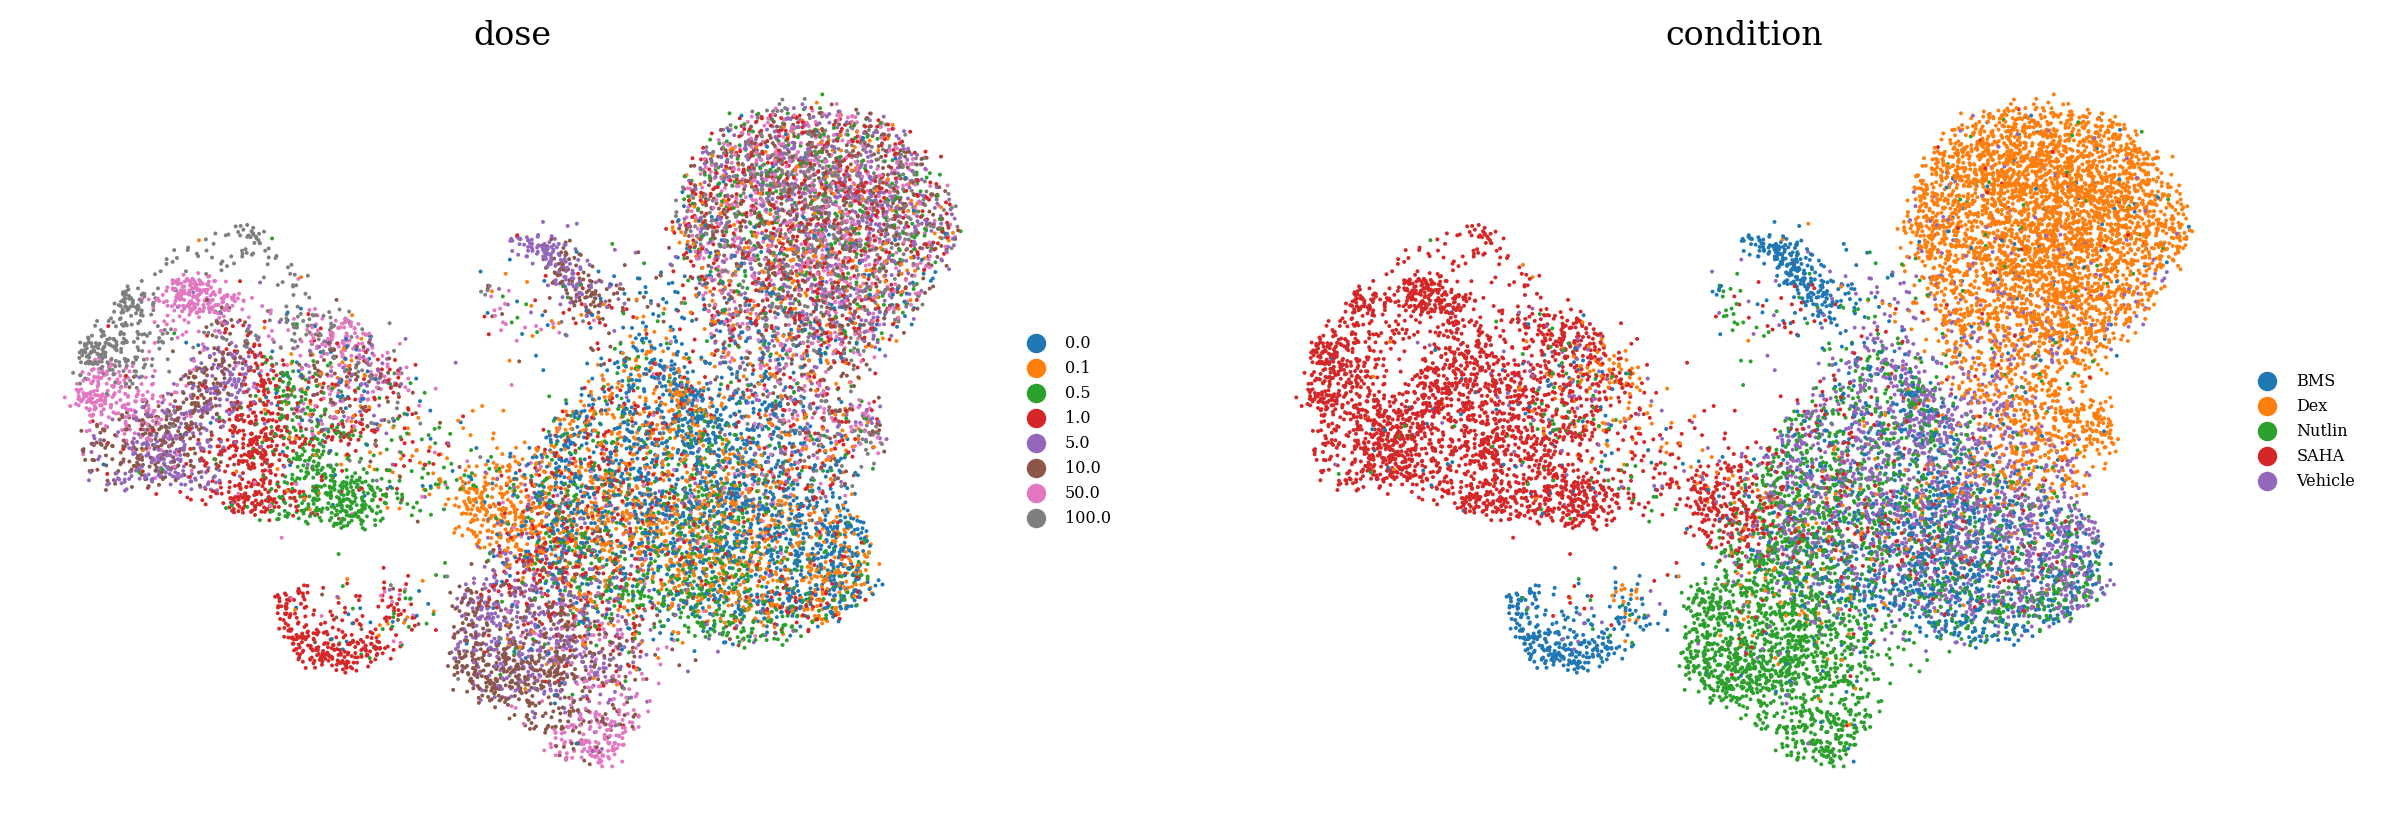

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

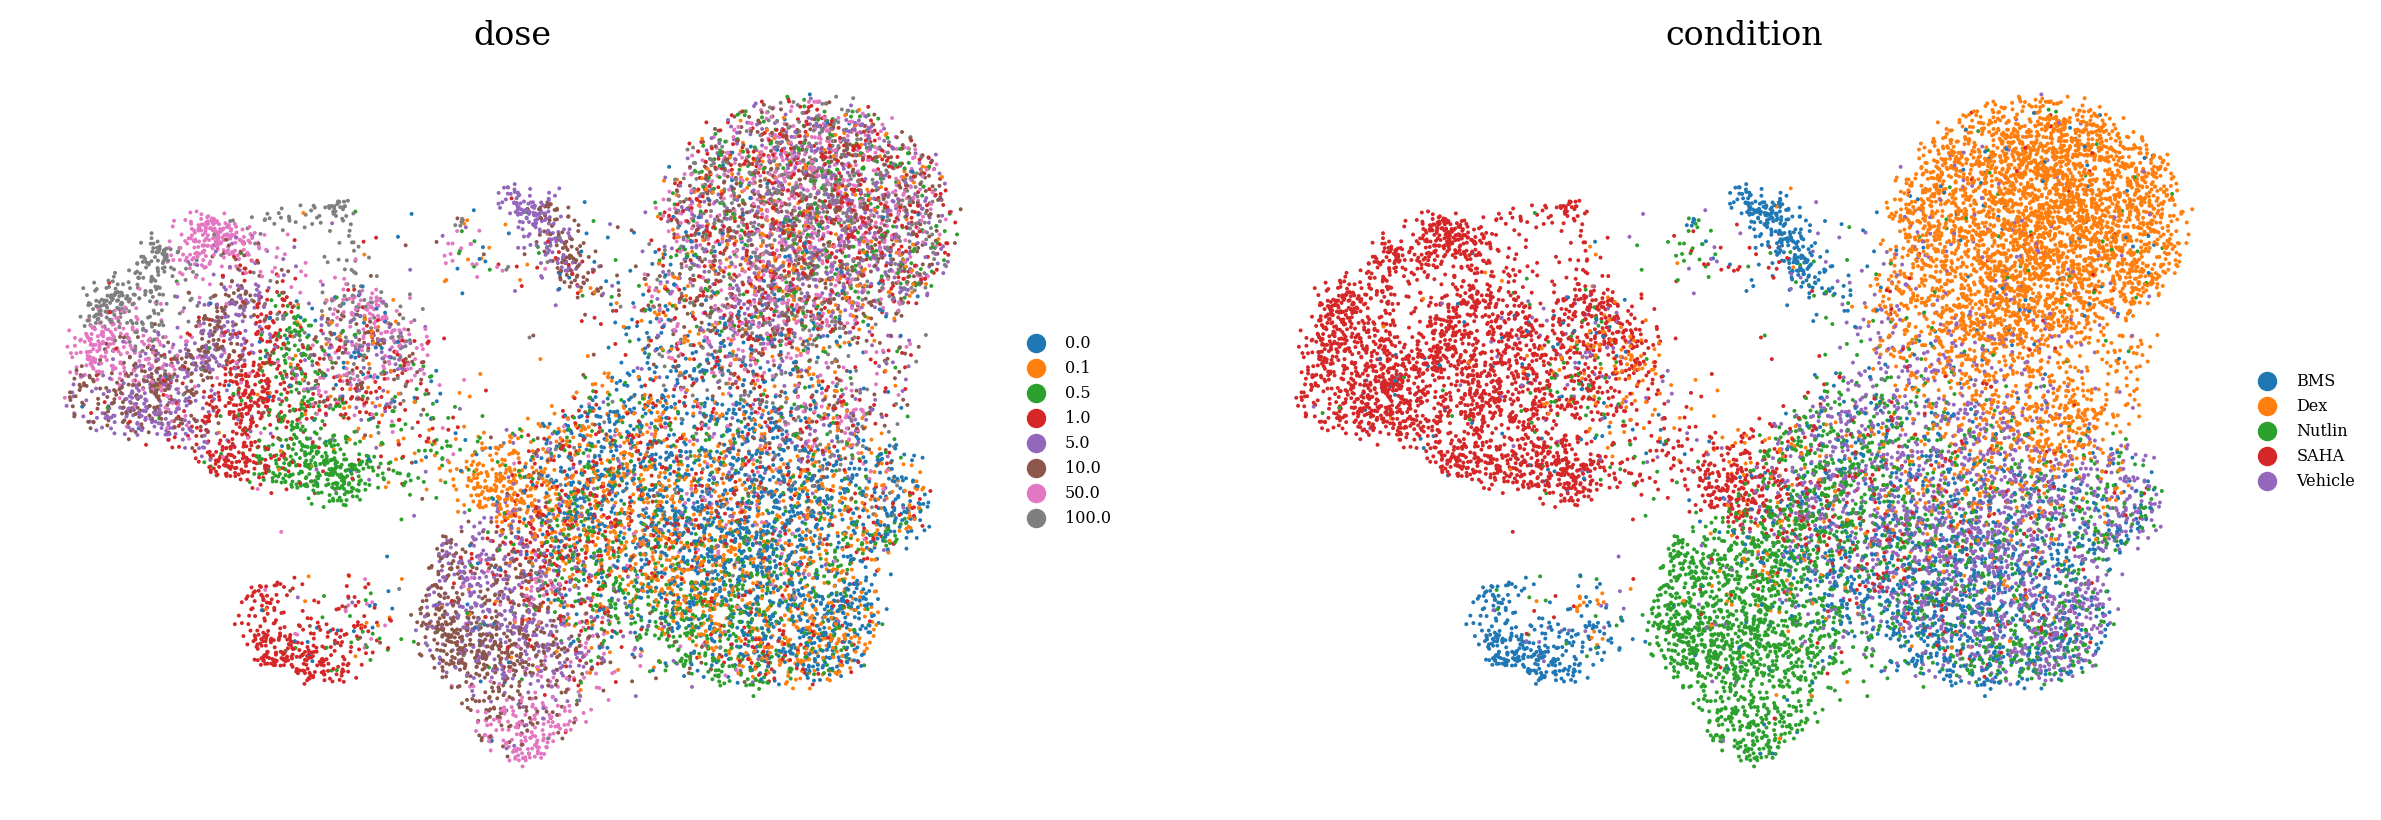

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  1%|          | 5/463 [00:00<00:09, 49.71it/s]

  6%|▋         | 30/463 [00:00<00:02, 164.85it/s]

 12%|█▏        | 55/463 [00:00<00:02, 200.54it/s]

 17%|█▋        | 80/463 [00:00<00:01, 216.44it/s]

 22%|██▏       | 104/463 [00:00<00:01, 224.61it/s]

 28%|██▊       | 128/463 [00:00<00:01, 229.74it/s]

 33%|███▎      | 152/463 [00:00<00:01, 232.88it/s]

 38%|███▊      | 177/463 [00:00<00:01, 235.59it/s]

 43%|████▎     | 201/463 [00:00<00:01, 236.90it/s]

 49%|████▉     | 226/463 [00:01<00:00, 238.16it/s]

 54%|█████▍    | 250/463 [00:01<00:00, 238.63it/s]

 59%|█████▉    | 275/463 [00:01<00:00, 239.11it/s]

 65%|██████▍   | 300/463 [00:01<00:00, 239.68it/s]

 70%|██████▉   | 324/463 [00:01<00:00, 239.50it/s]

 75%|███████▌  | 349/463 [00:01<00:00, 239.86it/s]

 81%|████████  | 373/463 [00:01<00:00, 239.62it/s]

 86%|████████▌ | 397/463 [00:01<00:00, 239.39it/s]

 91%|█████████ | 421/463 [00:01<00:00, 239.56it/s]

 96%|█████████▋| 446/463 [00:01<00:00, 239.72it/s]

100%|██████████| 463/463 [00:02<00:00, 230.52it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9718277675299807

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)